In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,MaxPooling2D,Conv2D,Dropout,Flatten
from tensorflow.keras.models import Sequential

import cv2
import os

In [ ]:
img = plt.imread("./test_1.png")
plt.imshow(img)

In [ ]:
# https://www.freedomvc.com/index.php/2022/01/17/basic-background-remover-with-opencv/

def bgremove1(myimage):
 
    # Blur to image to reduce noise
    myimage = cv2.GaussianBlur(myimage,(5,5), 0)
 
    # We bin the pixels. Result will be a value 1..5
    bins=np.array([0,51,102,153,204,255])
    myimage[:,:,:] = np.digitize(myimage[:,:,:],bins,right=True)*51
 
    # Create single channel greyscale for thresholding
    myimage_grey = cv2.cvtColor(myimage, cv2.COLOR_BGR2GRAY)
 
    # Perform Otsu thresholding and extract the background.
    # We use Binary Threshold as we want to create an all white background
    ret,background = cv2.threshold(myimage_grey,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
 
    # Convert black and white back into 3 channel greyscale
    background = cv2.cvtColor(background, cv2.COLOR_GRAY2BGR)
 
    # Perform Otsu thresholding and extract the foreground.
    # We use TOZERO_INV as we want to keep some details of the foregorund
    ret,foreground = cv2.threshold(myimage_grey,0,255,cv2.THRESH_TOZERO_INV+cv2.THRESH_OTSU)  #Currently foreground is only a mask
    foreground = cv2.bitwise_and(myimage,myimage, mask=foreground)  # Update foreground with bitwise_and to extract real foreground
 
    # Combine the background and foreground to obtain our final image
    finalimage = background+foreground
 
    return finalimage




def bgremove2(myimage):
    # First Convert to Grayscale
    myimage_grey = cv2.cvtColor(myimage, cv2.COLOR_BGR2GRAY)
 
    ret,baseline = cv2.threshold(myimage_grey,127,255,cv2.THRESH_TRUNC)
 
    ret,background = cv2.threshold(baseline,126,255,cv2.THRESH_BINARY)
 
    ret,foreground = cv2.threshold(baseline,126,255,cv2.THRESH_BINARY_INV)
 
    foreground = cv2.bitwise_and(myimage,myimage, mask=foreground)  # Update foreground with bitwise_and to extract real foreground
 
    # Convert black and white back into 3 channel greyscale
    background = cv2.cvtColor(background, cv2.COLOR_GRAY2BGR)
 
    # Combine the background and foreground to obtain our final image
    finalimage = background+foreground
    return finalimage



def bgremove3(myimage):
    # BG Remover 3
    myimage_hsv = cv2.cvtColor(myimage, cv2.COLOR_BGR2HSV)
     
    #Take S and remove any value that is less than half
    s = myimage_hsv[:,:,1]
    s = np.where(s < 127, 0, 1) # Any value below 127 will be excluded
 
    # We increase the brightness of the image and then mod by 255
    v = (myimage_hsv[:,:,2] + 127) % 255
    v = np.where(v > 127, 1, 0)  # Any value above 127 will be part of our mask
 
    # Combine our two masks based on S and V into a single "Foreground"
    foreground = np.where(s+v > 0, 1, 0).astype(np.uint8)  #Casting back into 8bit integer
 
    background = np.where(foreground==0,255,0).astype(np.uint8) # Invert foreground to get background in uint8
    background = cv2.cvtColor(background, cv2.COLOR_GRAY2BGR)  # Convert background back into BGR space
    foreground=cv2.bitwise_and(myimage,myimage,mask=foreground) # Apply our foreground map to original image
    finalimage = background+foreground # Combine foreground and background
   
    return finalimage

In [ ]:
# Read image
img  = cv2.imread("./test_1.png")
img1 = bgremove1(img)
img2 = bgremove2(img)
img3 = bgremove3(img)
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()
plt.imshow(img3)
plt.show()

In [2]:
path='./Data/images/'
file=os.listdir('./Data/images/')

features=[]
labels=[]

for img in file:
    label=int(img[:3])
    labels.append(label)
    img_array=cv2.imread(os.path.join(path,img),cv2.IMREAD_COLOR)
    img_array=cv2.resize(img_array,(220,220))
    features.append(img_array)
    

In [3]:
df = pd.DataFrame(labels)
df.value_counts()

6     100
2      93
4      90
9      90
7      89
5      88
10     84
1      82
3      61
8      55
dtype: int64

C:\Users\Malitha\anaconda3\envs\keras_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


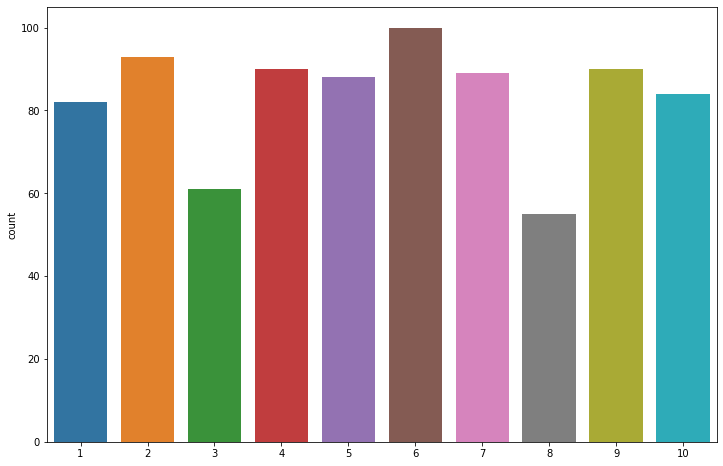

In [4]:
plt.figure(figsize=(12,8))
sns.countplot(labels)
plt.show()

In [5]:
name_dict={'001': 'Danaus_plexippus', '002': 'Heliconius_charitonius', '003': 'Heliconius_erato', '004': 'Junonia_coenia', '005': 'Lycaena_phlaeas', 
        '006': 'Nymphalis_antiopa', '007': 'Papilio_cresphontes', '008': 'Pieris_rapae', '009': 'Vanessa_atalanta', '0010': 'Vanessa_cardui'} 

list_labels=[]

for i in labels:
    new_label=name_dict['00'+str(i)]
    list_labels.append(new_label)
    

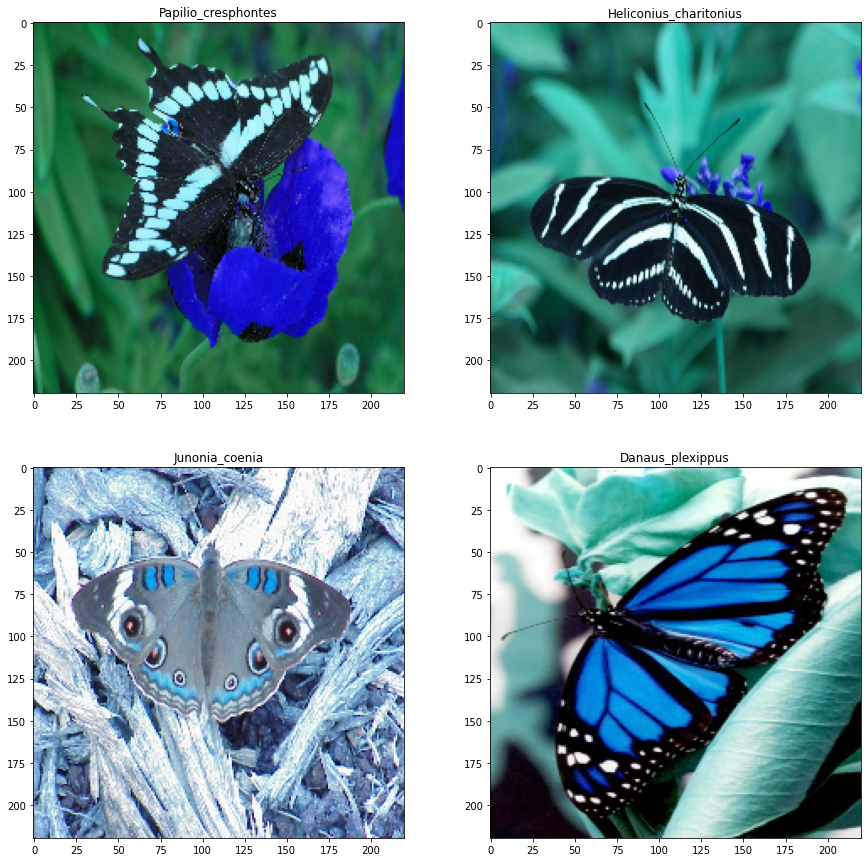

In [6]:
fig,ax=plt.subplots(2,2)
fig.set_size_inches(15,15)
for i in range(2):
    for j in range (2):
        l=np.random.randint(0,len(labels))
        ax[i,j].imshow(features[l])
        ax[i,j].set_title(str(list_labels[l]))        


In [8]:
le=LabelEncoder()
y=le.fit_transform(list_labels)
y=to_categorical(y)
y.shape

(832, 10)

In [9]:
features[0].shape

(220, 220, 3)

In [10]:
features=np.array(features)
features=features/255.0
features=features.reshape(-1,220,220,3)

In [11]:
features.shape

(832, 220, 220, 3)

In [13]:
x_train,x_test,y_train,y_test=train_test_split(features,y,random_state=42,test_size=0.2)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(665, 220, 220, 3) (167, 220, 220, 3) (665, 10) (167, 10)


In [14]:
x_train[0]

array([[[0.51372549, 0.52941176, 0.52156863],
        [0.58823529, 0.54901961, 0.53333333],
        [0.58431373, 0.58431373, 0.54901961],
        ...,
        [0.47058824, 0.50196078, 0.54509804],
        [0.47058824, 0.5372549 , 0.57647059],
        [0.58823529, 0.68235294, 0.73333333]],

       [[0.72156863, 0.69803922, 0.6627451 ],
        [0.63921569, 0.63137255, 0.60784314],
        [0.54117647, 0.52156863, 0.49411765],
        ...,
        [0.40784314, 0.45882353, 0.49803922],
        [0.48627451, 0.57254902, 0.62745098],
        [0.42745098, 0.52941176, 0.58823529]],

       [[0.85490196, 0.81176471, 0.79215686],
        [0.6745098 , 0.70588235, 0.70196078],
        [0.74117647, 0.79215686, 0.78823529],
        ...,
        [0.41176471, 0.44705882, 0.47843137],
        [0.40392157, 0.4627451 , 0.52156863],
        [0.50980392, 0.58039216, 0.62352941]],

       ...,

       [[0.33333333, 0.34117647, 0.41960784],
        [0.58823529, 0.55686275, 0.58823529],
        [0.58039216, 0

In [16]:
mnet = tensorflow.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, 
                                                      input_shape=(220, 220, 3),#same as of custom model
                                                      pooling='avg',
                                                      weights='imagenet')

model2=Sequential([
    mnet,
    Dropout(0.25),
    Dense(10,activation='softmax') # here we use 10 layers because we have to predict bewtween 10 classes
])

model2.layers[0].trainable = False
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

history2=model2.fit(x_train,y_train,batch_size=12, epochs=10,validation_split=0.3)

Epoch 1/10
39/39 [==============================] - 12s 260ms/step - loss: 1.7343 - acc: 0.4172 - val_loss: 1.0148 - val_acc: 0.7650
Epoch 2/10
39/39 [==============================] - 9s 244ms/step - loss: 0.6475 - acc: 0.8710 - val_loss: 0.5528 - val_acc: 0.9000
Epoch 3/10
39/39 [==============================] - 9s 236ms/step - loss: 0.3409 - acc: 0.9441 - val_loss: 0.4003 - val_acc: 0.9550
Epoch 4/10
39/39 [==============================] - 9s 240ms/step - loss: 0.2359 - acc: 0.9720 - val_loss: 0.3207 - val_acc: 0.9500
Epoch 5/10
39/39 [==============================] - 9s 231ms/step - loss: 0.1799 - acc: 0.9742 - val_loss: 0.2654 - val_acc: 0.9650
Epoch 6/10
39/39 [==============================] - 9s 229ms/step - loss: 0.1279 - acc: 0.9957 - val_loss: 0.2373 - val_acc: 0.9650
Epoch 7/10
39/39 [==============================] - 9s 229ms/step - loss: 0.1008 - acc: 0.9957 - val_loss: 0.2208 - val_acc: 0.9650
Epoch 8/10
39/39 [==============================] - 9s 229ms/step - loss: 0

In [17]:
loss,accuracy=model2.evaluate(x_test,y_test)

6/6 [==============================] - 2s 330ms/step - loss: 0.2253 - acc: 0.9641


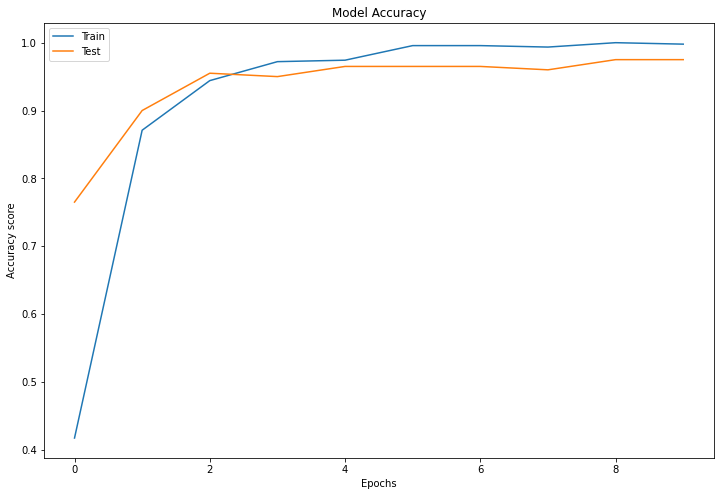

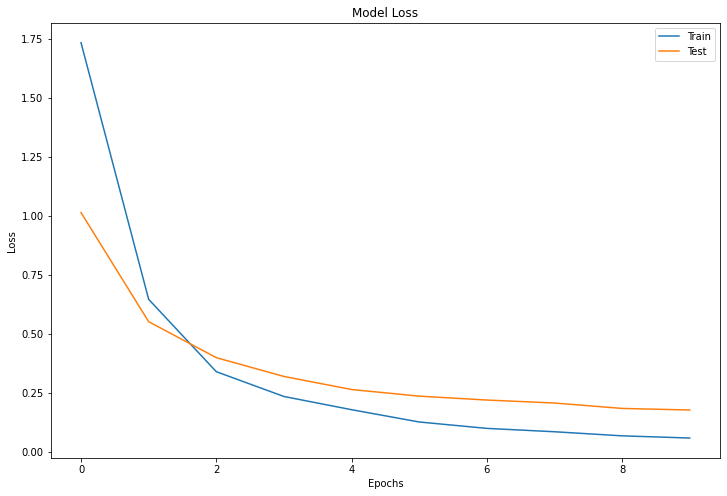

In [18]:
plt.figure(figsize=(12,8))
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy score')
plt.title('Model Accuracy')
plt.legend(['Train','Test'])
plt.show()

plt.figure(figsize=(12,8))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend(['Train','Test'])
plt.show()